Jensen Shanon Graph Kernel Using Information Functionals 
https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1775.pdf

Consider the graph $G=(V,E)$ with the node set $V= v_1,\dots,v_n$ and edge set $E=e_1,\dots e_n \subset v \times v $. The set of nodes 

$$S_{j}(v_i,G) = \{ v \in V | d(v_i,v) = j , j \geq 1 \} $$



*   Node Functional

    consider the graph $G=(V,E).$ For node $v_i \in V$, the information functional $f^{V}$ is defined as :
    $$f^{V}(v_i) := \alpha^{c_1|S_1(v_i,G)|+\dots+c_{\rho}  |S_{\rho}(v_i,G)| }$$



In [ ]:
#install python-igraph : we use IGraph for manipulating and storing graph data

!pip install python-igraph
!pip install cairocffi

     |████████████████████████████████| 3.2MB 11.7MB/s 
     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=6a5d6e225e8ab64560247cedaa90552aec44858dd7caa660d4fa25805806c695
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


In [ ]:
import os
import igraph as ig
from collections import Counter
from IPython.core.display import display, Image
from scipy.stats import entropy

In [ ]:
#mounting the data  on drive 

from google.colab import drive
drive.mount('/content/drive')
path = 'data/graph_data'

Mounted at /content/drive


In [ ]:
#retreving the file names
def get_data(path):
  graph_files = []
  for file in os.listdir(path):
    if file.endswith('gml'):
        graph_files.append(os.path.join(path,file))
  graph_files.sort()
  return graph_files
  

In [ ]:
def read_gml(filename):
  node_features = []
  g = ig.read(filename)
  if not 'label' in g.vs.attribute_names():
    g.vs['label'] = list(map(str,[l for l in g.vs.degree()]))
  node_features = g.vs['label']
  adj_mat  = np.asarray(g.get_adjacency().data)  
  return node_features,adj_mat

In [ ]:
#making sure that multiple igraph plots are shown in single jupyter cell

def plot(G,id):
  print("Graph "+id,end= "\n\n")
  ig.plot(G,bbox = (200, 200)).save('temporary.png') 
  display(Image(filename='temporary.png'))
  os.remove('temporary.png')

Graph G1



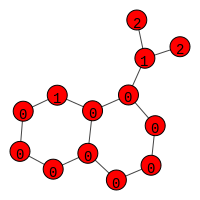

Graph G2



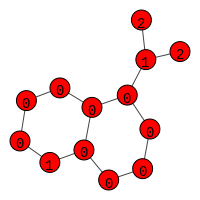

In [ ]:
#sample graph

path = '/content/drive/MyDrive/data/graph_data/MUTAG'
graph_files = get_data(path)
G0 = ig.read(graph_files[1])
G1 = ig.read(graph_files[2])
plot(G0,"G1")
plot(G1,"G2")

In [ ]:
def node_functional(g,alpha=2):
  """
  graph 
  Returns 
  ----------
  returns node_functional of graph
  """

  Eg = np.asarray(g.get_adjacency(attribute = "weight").data)
  csr_graph = csr_matrix(Eg)
  dist_matrix = johnson(csgraph=csr_graph, directed=False)
  fs = []
  for v in g.vs:
    temp = dist_matrix[v.index]
    unique, counts = np.unique(temp, return_counts=True) 
    rho = counts.shape[0]
    b_k = rho - np.arange(1,rho+1) + 1
    pow = (counts * b_k).sum()
    fs.append(alpha**pow)

  retur






In [ ]:
def entropy_with_functional(graph):
  """
  f : |V| values 
  """
  node = node_functional(graph)
  ent  = entropy(values)  
  return ent

In [ ]:
def disjoint_union_graph(g1,g2):
  """
  g1 : graph
  g2 : graph
  Returns:
  ---------
  disjoint union graph
  """

  product_graph = ig.disjoint_union([g1,g2])
  return product_graph

In [ ]:
def direct_product_graph(g1,g2):
  """
  g1 : graph
  g2 : graph
  Returns:
  -----------
  direct product graph
  """

  product_graph = ig.Graph()
  for v1 in g1.vs:
    for v2 in g2.vs:
      if v1['label'] == v2['label']:
        product_graph.add_vertex(id=(v1['id'],v2['id']), label=v1['label'] )

  for e1 in g1.es:
    for e2 in g2.es:
      if e1['weight'] == e2['weight']:
        
        #check whether a vertex actually to product graph
        e1_source_vertex,e1_target_vertex = g1.vs[e1.source],g1.vs[e1.target]
        e2_source_vertex,e2_target_vertex = g2.vs[e2.source],g2.vs[e2.target]
        
        if(e1_source_vertex['label'] == e2_source_vertex['label'] and e1_target_vertex['label'] == e2_target_vertex['label']):

          v1 = product_graph.vs.find(id=(e1_source_vertex['id'],e2_source_vertex['id']))
          v2 = product_graph.vs.find(id=(e1_target_vertex['id'],e2_target_vertex['id']))
          product_graph.add_edge(v1.index,v2.index, weight=e1['weight'])     
               
  return product_graph

In [ ]:
#calculating Kernel Matrix of Graph according to contiguous label sequences


def jsif_kernel_mat(graphs):
  N_gs = len(graphs)
  Kernel = np.zeros((N_gs,N_gs))
  for i,j in tqdm(combinations_with_replacement(range(N_gs),2)):

    graph_product = direct_product(graphs[i],graphs[j])
    H_gp = entropy_with_functional(graph_product)
    H_g1 = entropy_with_functional(graphs[i])
    H_g2 = entropy_with_functional(graphs[j])
    H_avg = (H_g1+H_g2)/2
    K    = math.log(2) - H_gp + H_avg
    Kernel[i][j] = Kernel[j][i] = K
  return Kernel  